In [2]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.offline import iplot
import datetime
from netCDF4 import Dataset
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.cluster import KMeans

import geojsoncontour
import json

with open('launion.json', 'r') as f:
  price_geojson = json.load(f)

## Visualización de datos

In [3]:
ncfile = Dataset('Data/outs_chimere/out.2020010500_168_base.online.cpl2.nc' , mode = 'r')

In [4]:
concentration1 = []
concentration2 = []

id = np.arange(0, 490, 1)

z = 24*7

for i in range(14):
    for j in range(35):
        concentration1.append(ncfile.variables['pBCAR'][:][z,0,i,j])

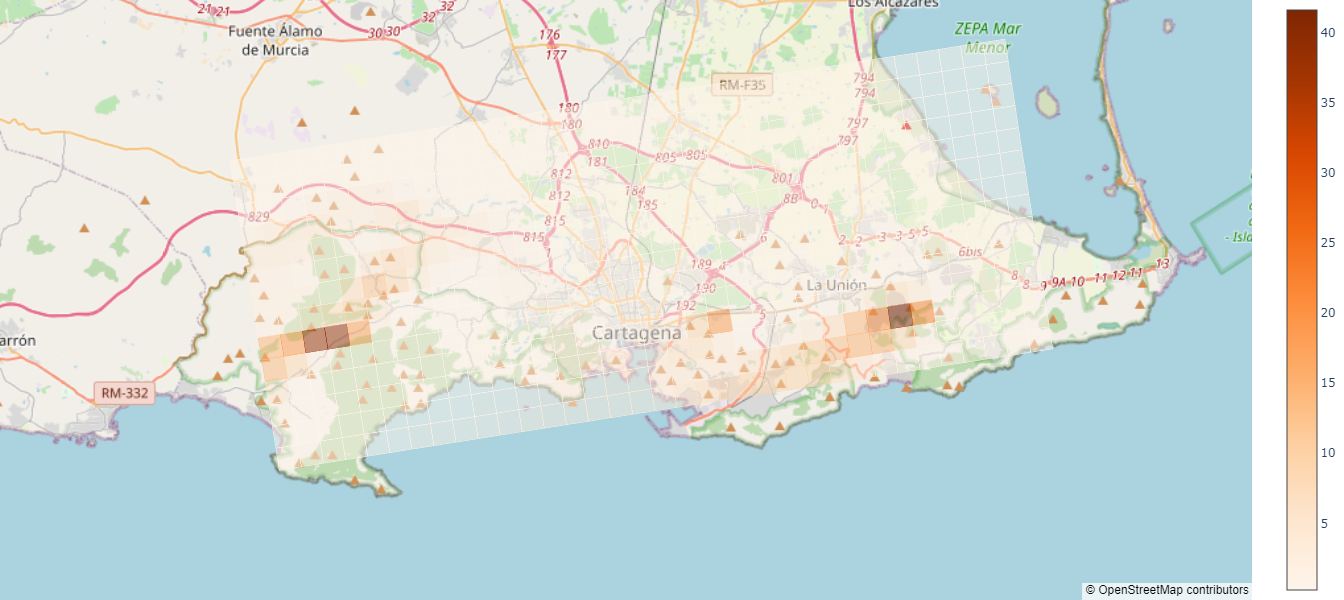

In [10]:
trace = go.Choroplethmapbox(
                            geojson = price_geojson,
                            locations = id ,
                            z = concentration1 ,
                            colorscale = "Oranges",
                            marker_line_width = 0.0,
                            marker=dict(opacity=0.5))
fig=go.Figure(trace)

fig.update_layout(mapbox_style="open-street-map",                                     #carto-positron
                  mapbox_zoom=10.4, mapbox_center = {"lat": 37.615, "lon": -0.99})

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0} , width =800, height=600)

# Proceso de clustering y PCA

### Almacenamiento de las medias temporales a lo largo de las celdillas para el mes correspondiente y añadirlas a un dataframe

In [20]:
bcar = []
ocar = []
pm10 = []
pm25 = []

cluster = pd.DataFrame()

for i in range(14):
    for j in range(14):
        bcar.append(np.mean(ncfile.variables['pBCAR'][:][:,0,i,j]) )
        
for i in range(14):
    for j in range(14):
        ocar.append(np.mean(ncfile.variables['pOCAR'][:][:,0,i,j]) )
        
for i in range(14):
    for j in range(14):
        pm10.append(np.mean(ncfile.variables['PM10'][:][:,0,i,j]) )
        
for i in range(14):
    for j in range(14):
        pm25.append(np.mean(ncfile.variables['PM25'][:][:,0,i,j]) )
        
cluster['bcar'] = bcar
cluster['ocar'] = ocar
cluster['pm10'] = pm10
cluster['pm25'] = pm25

In [21]:
cluster.head()

,bcar,ocar,pm10,pm25
0,0.366054,0.349646,4.505435,4.237618
1,0.361668,0.350881,4.280138,4.004901
2,0.369045,0.375087,4.025681,3.729191
3,0.382477,0.397692,3.880076,3.568683
4,0.374658,0.395670,3.813888,3.487269


### Normalizamos el dataframe

In [22]:
cluster_norm = (cluster - cluster.min()) / (cluster.max() - cluster.min()) 

cluster_norm.describe()

,bcar,ocar,pm10,pm25
count,196.000000,196.000000,196.000000,196.000000
mean,0.024274,0.025098,0.044697,0.044727
std,0.081574,0.081562,0.080342,0.080475
min,0.000000,0.000000,0.000000,0.000000
25%,0.002155,0.002516,0.015669,0.014999
50%,0.006316,0.007416,0.031463,0.032115
75%,0.016013,0.017560,0.051311,0.051800
max,1.000000,1.000000,1.000000,1.000000


### Calculo de numero de clusters optimo

In [23]:
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i , max_iter= 300)
    kmeans.fit(cluster_norm)
    wcss.append(kmeans.inertia_)

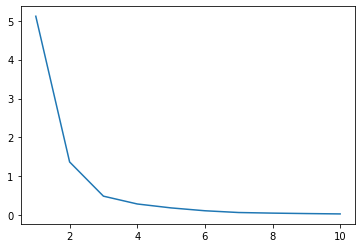

In [24]:
plt.plot(range(1,11) , wcss)

## Aplico procesamiento de clasificación (clustering)

In [25]:
clustering = KMeans(n_clusters = 3, max_iter = 300)
clustering.fit(cluster_norm)

KMeans(n_clusters=3)

In [26]:
cluster['cluster'] = clustering.labels_

cluster.head()

,bcar,ocar,pm10,pm25,cluster
0,0.366054,0.349646,4.505435,4.237618,0
1,0.361668,0.350881,4.280138,4.004901,0
2,0.369045,0.375087,4.025681,3.729191,0
3,0.382477,0.397692,3.880076,3.568683,0
4,0.374658,0.395670,3.813888,3.487269,0


In [27]:
for i in range(len(cluster.cluster)):
    if cluster.cluster[i] !=0:
        print(i)

80
81
93
94
95
96
97
134
135


### Análisis de PCA (Componentes principales)

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_cluster = pca.fit_transform(cluster_norm)

pca_data = pd.DataFrame(data = pca_cluster , columns = ['PCA1' , 'PCA2'] )
pca_data['cluster'] = clustering.labels_

pca_data

,PCA1,PCA2,cluster
0,-0.042812,-0.005070,0
1,-0.048504,-0.010693,0
2,-0.054211,-0.018084,0
3,-0.057059,-0.022791,0
4,-0.059115,-0.024394,0
...,...,...,...
191,-0.002518,0.046866,0
192,0.001098,0.050309,0
193,0.002739,0.050734,0
194,0.004367,0.051428,0


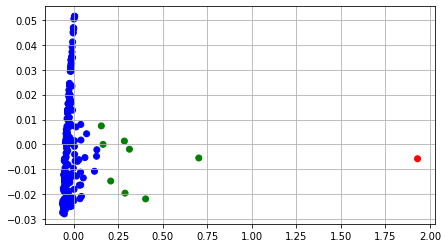

In [31]:
plt.figure(figsize = (7,4))

color_theme = np.array(['blue' , 'red' , 'green'])


plt.scatter(pca_data.PCA1 , pca_data.PCA2 , c= color_theme[pca_data.cluster])
plt.grid()